# The Factors

- Calculate the univariate performance characteristics of the the market factor (**MKT**), size factor (**SMB**), and value factor (**HML**)

- mean
- sharpe
- VaR(.05)

In [428]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'figure.figsize':(15, 6)})

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Helper Functions

In [429]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [430]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [431]:
def tangency_portfolio_rfr(asset_return,cov_matrix):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

In [432]:
file_path = 'C:/Users/dcste/OneDrive/Portfolio_Theory/Homework_Jupyter/portfolio_theory/dfa_analysis_data.xlsx'
info = pd.read_excel(file_path, sheet_name='descriptions')
info = info.rename(columns ={'Unnamed: 0': "Factor"})
info

,Factor,Name,Unit,Construction,Description
0,Mkt-RF,Market,Excess Return,Market-cap-weighted,US Equities
1,SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
2,HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
3,RF,Risk-free rate,Total Return,Tbills,NaN


In [433]:
# The factor data is already given as excess returns so simply drop the RF Column

factors = pd.read_excel(file_path, sheet_name='factors').set_index("Date")
factors = factors.drop(['RF'], axis = 1)
factors.head(3)

,Mkt-RF,SMB,HML
Date,,,
1926-07-31,0.0296,-0.0256,-0.0243
1926-08-31,0.0264,-0.0117,0.0382
1926-09-30,0.0036,-0.0140,0.0013


In [434]:
performance_summary(factors)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
Mkt-RF,0.080753,0.185161,0.436121,0.163951,7.527308,-0.079590,-0.120688,-0.2913,0.3885,-0.846853,1929-08-31,1932-06-30,1945-02-28
SMB,0.023288,0.109910,0.211879,1.844862,18.780704,-0.042035,-0.058576,-0.1723,0.3656,-0.548174,1983-07-31,1999-03-31,2021-01-31
HML,0.042318,0.123363,0.343037,2.113333,18.514786,-0.041935,-0.066259,-0.1397,0.3561,-0.584280,2006-12-31,2020-09-30,NaT


# Report the univariate performance subsample statistics

- Beginning to 1980
- 1981 to 2001
- 2002-Present Day

In [435]:
sub_1980 = factors.loc[:"1980",:]
sub_2001 = factors.loc['1981':'2001',:]
sub_present = factors.loc['2002':'2022',:]

df_dict = {'1926-1980': sub_1980,'1981-2001': sub_2001,'2002-2022':sub_present}

In [436]:

summary_lst = []

for key in df_dict.keys():
    summary_stats = performance_summary(df_dict[key]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
    summary_stats['Period'] = key
    summary_stats = summary_stats.reset_index().rename(columns= {'index':'Factor'}).set_index(['Period','Factor'])
    summary_lst.append(summary_stats)    

In [437]:
summary_lst = pd.concat(summary_lst)
summary_lst

Mean  Volatility  Sharpe Ratio  VaR (0.05)
Period    Factor                                                
1926-1980 Mkt-RF  0.081138    0.205050      0.395696   -0.083985
          SMB     0.033985    0.114568      0.296638   -0.043400
          HML     0.049479    0.133825      0.369727   -0.042910
1981-2001 Mkt-RF  0.077257    0.157396      0.490847   -0.064545
          SMB    -0.000876    0.118434     -0.007398   -0.046560
          HML     0.063729    0.111276      0.572706   -0.041790
2002-2022 Mkt-RF  0.083289    0.153972      0.540933   -0.078795
          SMB     0.019631    0.085788      0.228826   -0.037785
          HML     0.001679    0.104507      0.016066   -0.041000

Text(0.5, 1.0, 'Historical Factor Performance')

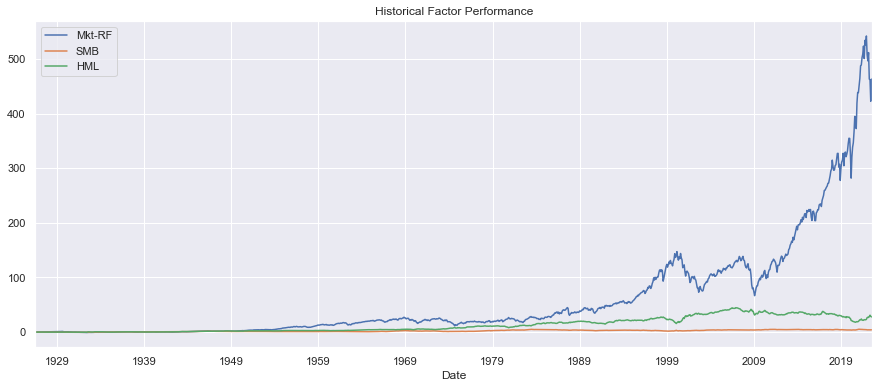

In [438]:
((1+factors).cumprod()-1).plot()
plt.title("Historical Factor Performance")

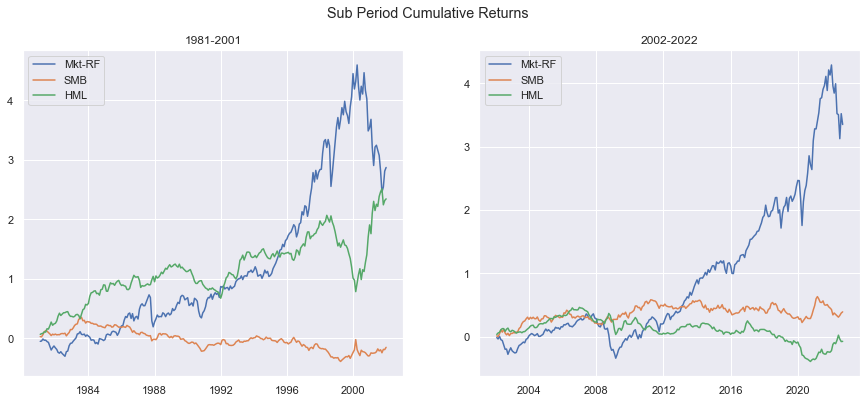

In [439]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_present + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax2.legend(sub_present.columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2022')

In [440]:
performance_summary(sub_present)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
Mkt-RF,0.083289,0.153972,0.540933,-0.526963,1.321451,-0.078795,-0.098869,-0.1723,0.1365,-0.515109,2007-10-31,2009-02-28,2012-03-31
SMB,0.019631,0.085788,0.228826,0.203484,-0.261138,-0.037785,-0.044631,-0.0594,0.0734,-0.227041,2011-03-31,2020-03-31,2021-01-31
HML,0.001679,0.104507,0.016066,-0.000844,3.484598,-0.041000,-0.063864,-0.1397,0.1275,-0.584280,2006-12-31,2020-09-30,NaT


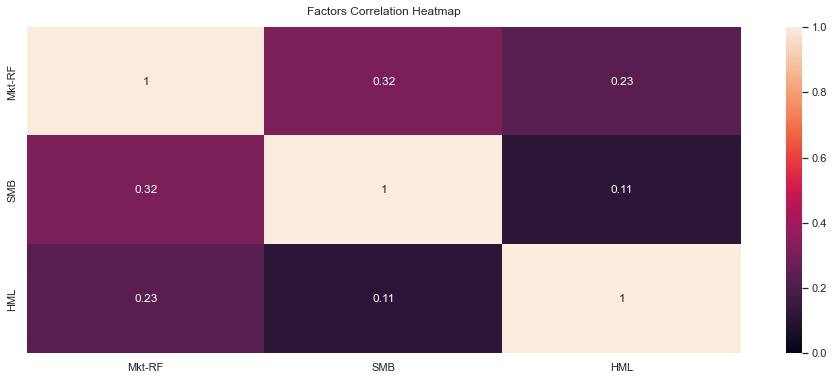

In [441]:
factor_corr = factors.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factor_corr, vmin=0, vmax=1, annot=True)
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

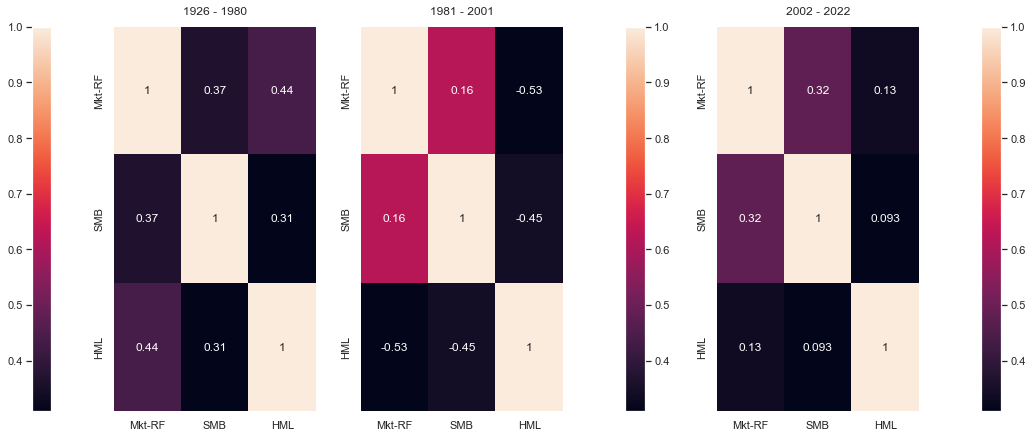

In [442]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_present.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2022', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

# The Capital Asset Pricing Model

The CAPM is concerned with the economic equilibrium of asset pricing. Mathematically, **The CAPM** asserts the portfolio's expected excess return is compltely a function of its beta to the equity market index (SPY). 

- DFA believes that premia on stocks and portfolios are related to the three factors. Let's test 25 portfolios that span a wide range of size and value measures.

In [443]:
# Get the risk-free rate from the factor data becausse we need to convert the portfolio data to excess returns not total returns

rf = pd.read_excel(file_path, sheet_name ='factors').set_index("Date")
# Getting portfolio returns
portfolios = pd.read_excel(file_path, sheet_name = 'portfolios (total returns)').set_index("Date")
rf = rf['RF'].to_frame()

In [444]:

portfolios = portfolios.subtract(rf['RF'], axis = 0)


In [445]:
portfolo_performance = performance_summary(portfolios.loc['1981-01-01':])
portfolo_performance.loc[:,["Mean","Volatility","Sharpe Ratio","VaR (0.05)"]]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.010463,0.272416,0.038410,-0.116482
ME1 BM2,0.095732,0.235906,0.405804,-0.097583
ME1 BM3,0.092913,0.197205,0.471147,-0.086441
ME1 BM4,0.119996,0.191374,0.627023,-0.075179
SMALL HiBM,0.132096,0.207677,0.636062,-0.088348
ME2 BM1,0.060281,0.245699,0.245346,-0.104558
ME2 BM2,0.100629,0.203156,0.495330,-0.084043
ME2 BM3,0.106615,0.183069,0.582375,-0.078669
ME2 BM4,0.107739,0.179220,0.601154,-0.076411
ME2 BM5,0.118123,0.212044,0.557067,-0.094234


Can the differences in the means be explained by the differences in their volatilities or by their VaR statistics? 

-0.398196282944545

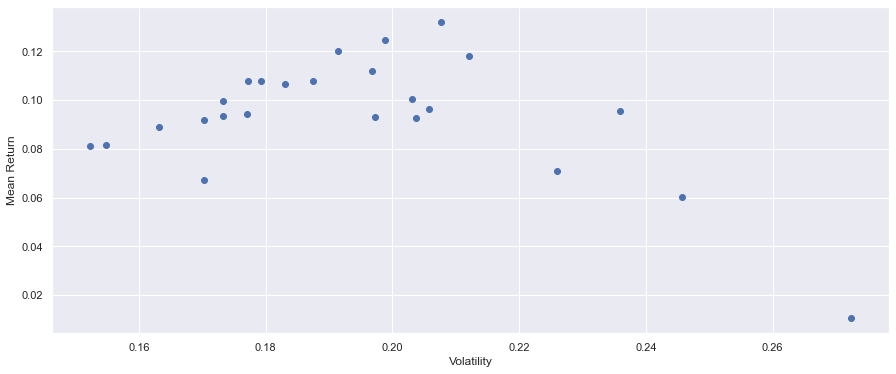

In [446]:
plt.scatter(portfolo_performance['Volatility'], portfolo_performance['Mean'])
plt.xlabel("Volatility")
plt.ylabel("Mean Return")

portfolo_performance.Volatility.corr(portfolo_performance.Mean)

0.4629052625211333

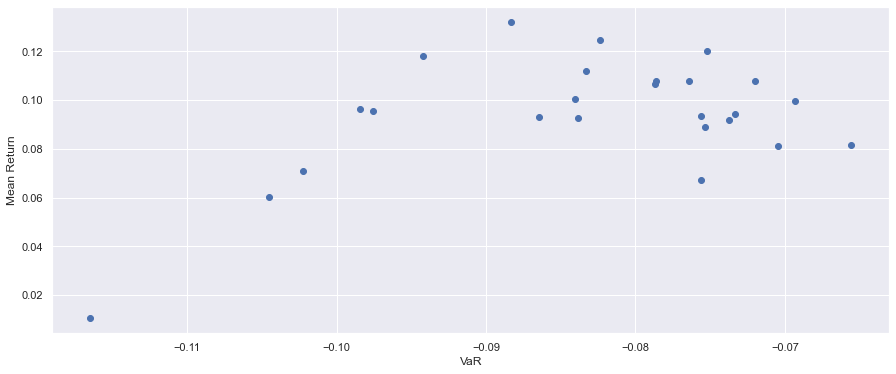

In [447]:
plt.scatter(portfolo_performance['VaR (0.05)'], portfolo_performance['Mean'])
plt.xlabel("VaR")
plt.ylabel("Mean Return")

portfolo_performance['VaR (0.05)'].corr(portfolo_performance.Mean)

No the no free lunch principle does not seem to be upheld after inspecting the relationships between average returns and risk. 

# 3.2 CAPM

For each asset of the n = 25 Portfolios, run the CAPM time-series regression: 

$\tilde{r}_{t}^{i} = α^{i} + β^{i,m}\tilde{r}^{m}_{t} + ε_{t}$

In [448]:
port_cols = portfolios.columns
factor = factors['1981-01-01':]['Mkt-RF']

df_lst = []
for port in port_cols:
    fund_ret = portfolios['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst.append(pd.DataFrame([[beta,alpha,r_squared,treynor_ratio,information_ratio]],columns=['Market Beta','Alpha','R-Squared','Treynor Ratio','Information Ratio'], index = [port]))

In [449]:
reg_performance = pd.concat(df_lst)
reg_performance

,Market Beta,Alpha,R-Squared,Treynor Ratio,Information Ratio
SMALL LoBM,1.360046,-0.098676,0.603114,0.007693,-0.574986
ME1 BM2,1.170212,0.001824,0.595400,0.081807,0.012154
ME1 BM3,1.036480,0.009732,0.668413,0.089642,0.085739
ME1 BM4,0.965225,0.042540,0.615535,0.124319,0.358477
SMALL HiBM,0.990693,0.052596,0.550631,0.133336,0.377783
ME2 BM1,1.343338,-0.047520,0.723306,0.044874,-0.367683
ME2 BM2,1.128609,0.010056,0.746773,0.089162,0.098400
ME2 BM3,1.019328,0.024816,0.750164,0.104593,0.271190
ME2 BM4,0.965384,0.030264,0.702078,0.111602,0.309418
ME2 BM5,1.108553,0.029160,0.661333,0.106556,0.236327


# Cross-Sectional Estimation

In [450]:
X = sm.add_constant(reg_performance['Market Beta'])

cross_test = sm.OLS(portfolios.loc['1981-01-01':].mean(),X).fit()
cross_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     8.008
Date:                Sun, 06 Nov 2022   Prob (F-statistic):            0.00950
Time:                        21:32:20   Log-Likelihood:                 123.51
No. Observations:                  25   AIC:                            -243.0
Df Residuals:                      23   BIC:                            -240.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0165      0.003      5.362      0.000       0.010       0.023
Market Beta    -0.0082      0.003     -2.830      0.009      -0.014      -0.002
==============================================================================
Omnibus:                        4.531   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                2.975
Skew:                          -0.820   Prob(JB):                        0.226
Kurtosis:                       3.408   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [496]:
pd.DataFrame([cross_test.params['const']*12,cross_test.params['Market Beta']*12, cross_test.rsquared],index = ['Alpha','Beta','R-squared'], columns = ['CAPM Test'])

,CAPM Test
Alpha,0.197981
Beta,-0.098158
R-squared,0.258245


# Testing the Fama-French 3-Factor Model

$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta^{i,m} \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}] +  \beta^{i,s} \mathop{\mathbb{E}}[\tilde{r}^{s}_{t}] +  \beta^{i,v} \mathop{\mathbb{E}}[\tilde{r}^{v}_{t}]$

In [452]:
port_cols = portfolios.columns
factor = factors['1981-01-01':]

df_lst_ff = []
for port in port_cols:
    fund_ret = portfolios['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,alpha,r_squared,treynor_ratio,information_ratio]],columns=['Market Beta','Size Beta','Value Beta','Alpha','R-Squared','Treynor Ratio','Information Ratio'], index = [port]))

In [455]:
famma_3f = pd.concat(df_lst_ff)
famma_3f

,Market Beta,Size Beta,Value Beta,Alpha,R-Squared,Treynor Ratio,Information Ratio
SMALL LoBM,1.116175,1.372219,-0.262905,-0.083196,0.891880,0.009374,-0.928832
ME1 BM2,0.972187,1.314518,-0.012622,0.005916,0.912405,0.098471,0.084678
ME1 BM3,0.921626,1.046313,0.277420,0.000084,0.945551,0.100814,0.001869
ME1 BM4,0.878290,1.057983,0.476788,0.023964,0.938066,0.136624,0.503265
SMALL HiBM,0.935865,1.060999,0.695626,0.024204,0.869853,0.141148,0.323126
ME2 BM1,1.142436,1.015023,-0.332342,-0.029880,0.940685,0.052765,-0.499362
ME2 BM2,1.012003,0.901247,0.120149,0.007080,0.939822,0.099435,0.142076
ME2 BM3,0.972962,0.707765,0.398220,0.008832,0.919854,0.109578,0.170470
ME2 BM4,0.940884,0.742195,0.579725,0.006228,0.937383,0.114508,0.138965
ME2 BM5,1.093340,0.921874,0.822365,-0.005280,0.951121,0.108038,-0.112717


# Testing the Famma-French 3-Factor Model VIA Cross-Sectional Regression

- We want to see a high-rsquared, low alpha, and statisitically signficant large betas 

In [459]:
X_f = sm.add_constant(famma_3f[['Market Beta','Size Beta','Value Beta']])
y_3f = portfolios.loc['1981-01-01':].mean()

Famma_3f_reg = sm.OLS(y_3f,X_f).fit()
Famma_3f_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     6.121
Date:                Sun, 06 Nov 2022   Prob (F-statistic):            0.00369
Time:                        21:38:56   Log-Likelihood:                 127.63
No. Observations:                  25   AIC:                            -247.3
Df Residuals:                      21   BIC:                            -242.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0150      0.005      3.311      0.003       0.006       0.024
Market Beta    -0.0080      0.004     -1.845      0.079      -0.017       0.001
Size Beta       0.0002      0.001      0.361      0.721      -0.001       0.002
Value Beta      0.0030      0.001      3.705      0.001       0.001       0.005
==============================================================================
Omnibus:                       15.621   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.758
Skew:                          -1.490   Prob(JB):                     0.000230
Kurtosis:                       5.685   Cond. No.                         30.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [495]:
pd.DataFrame([Famma_3f_reg.params[0]*12,Famma_3f_reg.params[1]*12, Famma_3f_reg.params[2]*12, Famma_3f_reg.params[3]*12, Famma_3f_reg.rsquared], index = ['Alpha','Market Beta','Size Beta','Value Beta','Rsquared'], columns = ['Famma-French Cross Sectional Test'])


,Famma-French Cross Sectional Test
Alpha,0.179740
Market Beta,-0.095676
Size Beta,0.002894
Value Beta,0.036210
Rsquared,0.466514
